# Setup

In [1]:
# Pandas and numpy necessary to do basic data cleaning
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
def gen_data(N, T, cohorts, effects, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale):
    
    # Set seed
    np.random.seed(5882300)

    # Combine people into dataset 
    ids    = np.tile(np.arange(1,N+1),T)
    time   = np.repeat(np.arange(1,T+1),N)
    cdf    = pd.DataFrame({'id':np.arange(1,N+1),'cohort':cohorts})
    df     = pd.DataFrame({'id':ids,'time':time})
    df     = df.merge(cdf, on='id', how='inner')

    # Add relative time and treatment indicator
    df['rel'] = df.time - df.cohort
    df['rel'] = np.where(df.cohort > T, -np.inf, df.rel)
    df['D']   = (df.rel >= 0).astype(int)

    # Add random person fixed effects and linear time trend.
    i_fe    = np.random.uniform(size=N) * i_fe_scale
    t_fe    = t_fe_trend + np.random.normal(loc=0.0,scale=t_fe_scale,size=T)
    i_fe_df = pd.DataFrame({'id':np.arange(1,N+1),'i_fe':i_fe})
    t_fe_df = pd.DataFrame({'time':np.arange(1,T+1),'t_fe':t_fe})
    df      = df.merge(i_fe_df, on='id', how='inner')
    df      = df.merge(t_fe_df, on='time', how='inner')

    # Random noise
    df['u0'] = np.random.normal(size=N*T, loc=0.0, scale=u0_scale)
    df['u1'] = np.random.normal(size=N*T, loc=0.0, scale=u1_scale)

    # Potential outcomes model
    df        = df.sort_values(['id','time'])
    df['att'] = effects
    df['y0']  = baseline + df.t_fe + df.i_fe + df.u0
    df['y1']  = baseline + df.t_fe + df.i_fe + df.att + df.u1
    df['y']   = df.D*(df.y1) + (1.0-df.D)*(df.y0)

    # Average by cohort
    agg_df = df.groupby(['cohort','time']).mean().reset_index()
    
    return df, agg_df

# 7(a) - Common Trends in Linear vs. Log

In [3]:
# DGP parameters
N          = 2    # Sample size
T          = 15   # Time periods
i_fe_scale = 8.0 # Individual fixed effects ~ Unif[0, i_fe_scale]
t_fe_scale = 0.0  # Time fixed effects = specified below + N(0, t_fe_scale)
u0_scale   = 0.0  # Variance of noise term added to Y(0)
u1_scale   = 0.0  # Variance of noise term added to Y(1)
baseline   = 5.0  # Baseline level of potential outcome

# How things change over time
t_fe_trend = np.arange(1,T+1)-5

# Cohorts
cohorts = np.array([10, 50])

# Treatment effects
effects = np.repeat(3.0, N*T)

# Get data 
df,agg_df = gen_data(N, T, cohorts, effects, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)

# Take logs
df['ln_y0'] = np.log(df.y0)
df['ln_y1'] = np.log(df.y1)
df['ln_y']  = np.log(df.y)

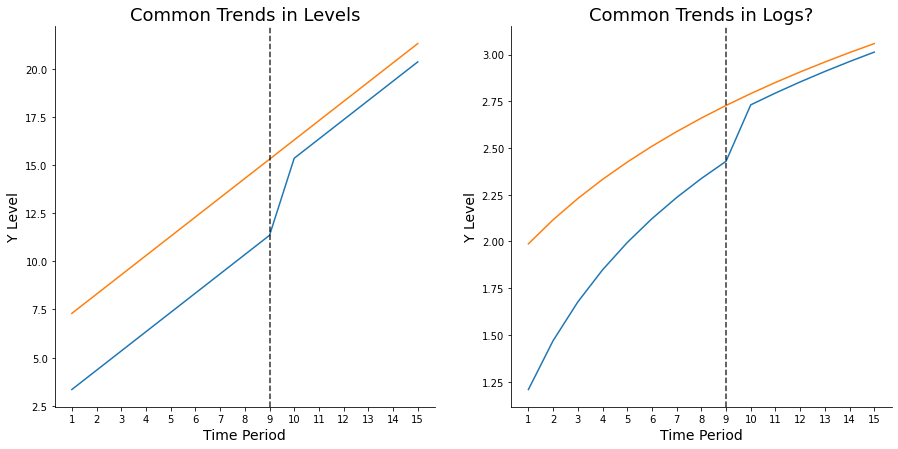

In [4]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
ax     = ax.flatten()

# Formatting stuff
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Plot 1 main stuff
ax[0].plot(df.loc[df.id == 1, 'time'], df.loc[df.id == 1, 'y'])
ax[0].plot(df.loc[df.id == 2, 'time'], df.loc[df.id == 2, 'y'])
ax[1].plot(df.loc[df.id == 1, 'time'], df.loc[df.id == 1, 'ln_y'])
ax[1].plot(df.loc[df.id == 2, 'time'], df.loc[df.id == 2, 'ln_y'])

# Vertical/horizontal lines
ax[0].axvline(x=9, color='black', linestyle='dashed', alpha=0.8)
ax[1].axvline(x=9, color='black', linestyle='dashed', alpha=0.8)

# Axis mess
ax[0].set_xticks(np.arange(1,T+1))
ax[1].set_xticks(np.arange(1,T+1))
ax[0].set_xlabel("Time Period", size=14)
ax[0].set_ylabel("Y Level", size=14)
ax[1].set_xlabel("Time Period", size=14)
ax[1].set_ylabel("Y Level", size=14)

# Titles
ax[0].set_title("Common Trends in Levels", size=18)
ax[1].set_title("Common Trends in Logs?", size=18)

# Save out
plt.savefig("./q7_output/q7a.png")
plt.show()

# 7(b) - Static TWFE: Negative Weights

In [5]:
# DGP parameters
N          = 300  # Sample size
T          = 30   # Time periods
i_fe_scale = 5.0  # Individual fixed effects ~ Unif[0, i_fe_scale]
t_fe_scale = 0.0  # Time fixed effects = specified below + N(0, t_fe_scale)
u0_scale   = 1.0  # Variance of noise term added to Y(0)
u1_scale   = 1.0  # Variance of noise term added to Y(1)
baseline   = 2.0  # Baseline level of potential outcome

# How things change over time
t_fe_trend = np.arange(1,T+1) 

# Cohorts
cohorts = np.concatenate((np.repeat(5, 150), 
                          np.repeat(9, 100), 
                          np.repeat(22, 50)))

# Treatment effects
effects = np.concatenate((np.tile(np.arange(1,T+1)*3.0,150), 
                          np.tile(np.arange(1,T+1)*1.0,100), 
                          np.tile(np.arange(1,T+1)*0.5,50)))

# Get data 
df,agg_df = gen_data(N, T, cohorts, effects, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)

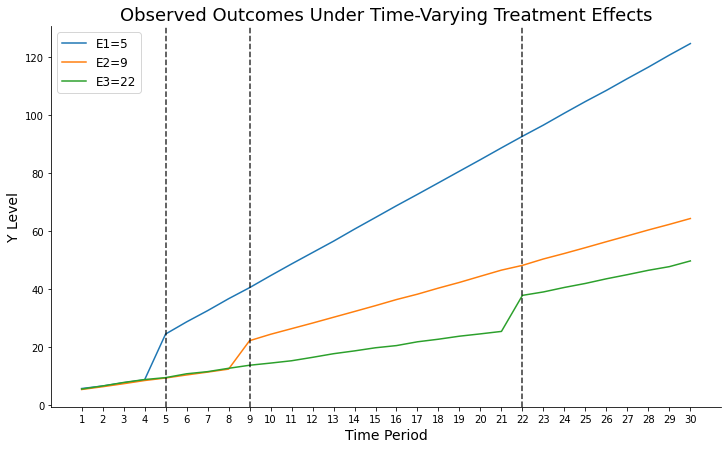

In [6]:
fig,ax = plt.subplots(figsize=(12,7))

# Formatting stuff
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot 1 main stuff
ax.plot(agg_df.loc[agg_df.cohort == 5, 'time'], agg_df.loc[agg_df.cohort == 5, 'y'])
ax.plot(agg_df.loc[agg_df.cohort == 9, 'time'], agg_df.loc[agg_df.cohort == 9, 'y'])
ax.plot(agg_df.loc[agg_df.cohort == 22, 'time'], agg_df.loc[agg_df.cohort == 22, 'y'])

# Vertical/horizontal lines
ax.axvline(x=5, color='black', linestyle='dashed', alpha=0.8)
ax.axvline(x=9, color='black', linestyle='dashed', alpha=0.8)
ax.axvline(x=22, color='black', linestyle='dashed', alpha=0.8)

# Axis mess
ax.set_xticks(np.arange(1,T+1))
ax.set_xlabel("Time Period", size=14)
ax.set_ylabel("Y Level", size=14)

# Legend
ax.legend(['E1=5','E2=9','E3=22'], fontsize=12)

# Titles
ax.set_title("Observed Outcomes Under Time-Varying Treatment Effects", size=18)

# Save out
plt.savefig("./q7_output/q7b_chart.png")
plt.show()

In [7]:
# Build regression df
reg_df            = copy.deepcopy(df)
reg_df['_const']  = 1.0
unit_dummies      = pd.get_dummies(df['id'])
time_dummies      = pd.get_dummies(df['time'])
unit_cols         = [f'i: {col}' for col in unit_dummies.columns]
time_cols         = [f't: {col}' for col in time_dummies.columns]
reg_df[unit_cols] = unit_dummies
reg_df[time_cols] = time_dummies

# Get regression matrices
X = np.array(reg_df[['D','_const']+unit_cols[:-1]+time_cols[:-1]])
y = np.array(reg_df['y'])[:,None]

# Get regression results
beta    = (np.linalg.inv(X.T @ X) @ X.T @ y)[0:2]
beta_df = pd.DataFrame({"Coefficient":["ATT Estimate","Intercept"], "Value":np.round(beta.ravel(),3)})
beta_df.to_latex("./q7_output/q7b_table.tex", index=False)
beta_df

,Coefficient,Value
0,ATT Estimate,-5.148
1,Intercept,72.607


# 7(c) - Dynamic TWFE: Positive Weights with Homogeneity, Negative Weights with Heterogeneity

In [8]:
# DGP parameters
N          = 600  # Sample size
T          = 15   # Time periods
i_fe_scale = 5.0  # Individual fixed effects ~ Unif[0, i_fe_scale]
t_fe_scale = 1.0  # Time fixed effects = specified below + N(0, t_fe_scale)
u0_scale   = 2.0  # Variance of noise term added to Y(0)
u1_scale   = 2.0  # Variance of noise term added to Y(1)
baseline   = 2.0  # Baseline level of potential outcome

# How things change over time
t_fe_trend = np.arange(1,T+1) 

# Cohorts
cohorts = np.concatenate((np.repeat(8,  350), 
                           np.repeat(10, 100), 
                           np.repeat(12, 50),
                           np.repeat(100, 100)))

# Treatment effects - homogeneous
effects1 = np.concatenate((np.tile(np.repeat(10.0,T), 350), 
                           np.tile(np.repeat(10.0,T), 100), 
                           np.tile(np.repeat(10.0,T), 50),
                           np.tile(np.repeat(10.0,T), 100)))

# Treatment effects - heterogeneous
effects2 = np.concatenate((np.tile(np.repeat(3.0,T),  350), 
                           np.tile(np.repeat(14.5,T), 100), 
                           np.tile(np.repeat(50.0,T), 50),
                           np.tile(np.repeat(10.0,T), 100)))

# Get data 
df1,agg_df1 = gen_data(N, T, cohorts, effects1, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)
df2,agg_df2 = gen_data(N, T, cohorts, effects2, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)

In [9]:
# Build regression dfs
dfs      = [df1,df2]
agg_dfs  = [agg_df1, agg_df2]
beta_dfs = []
for i in range(len(dfs)):
    
    reg_df               = dfs[i].copy()
    reg_df['_const']     = 1.0
    
    # Make unit dummies, time dummies, relative time dummies
    unit_dummies         = pd.get_dummies(dfs[i]['id'])
    time_dummies         = pd.get_dummies(dfs[i]['time'])
    reltime_dummies      = pd.get_dummies(dfs[i]['rel'])
    unit_cols            = [f'i: {col}' for col in unit_dummies.columns if col != 1]
    time_cols            = [f't: {col}' for col in time_dummies.columns if col != 1]
    reltime_min          = np.min(reltime_dummies.columns)
    reltime_nums         = [f'{int(col)}' for col in reltime_dummies.columns if ((col != -1) & (col != reltime_min))] 
    reltime_cols         = [f'r: {col}' for col in reltime_nums]
    reg_df[unit_cols]    = unit_dummies.drop(1, axis=1)
    reg_df[time_cols]    = time_dummies.drop(1, axis=1)
    reg_df[reltime_cols] = reltime_dummies.drop([-1, reltime_min], axis=1)
        
    # Get regression matrices
    X = np.array(reg_df[reltime_cols + unit_cols + time_cols + ['_const']])
    y = np.array(reg_df['y'])[:,None]
    
    # Get regression results
    beta    = (np.linalg.inv(X.T @ X) @ X.T @ y).ravel()
    beta_df = pd.DataFrame({"Coefficient": reltime_nums, 
                            "Value": beta[0:len(reltime_cols)]})
    beta_dfs.append(beta_df)

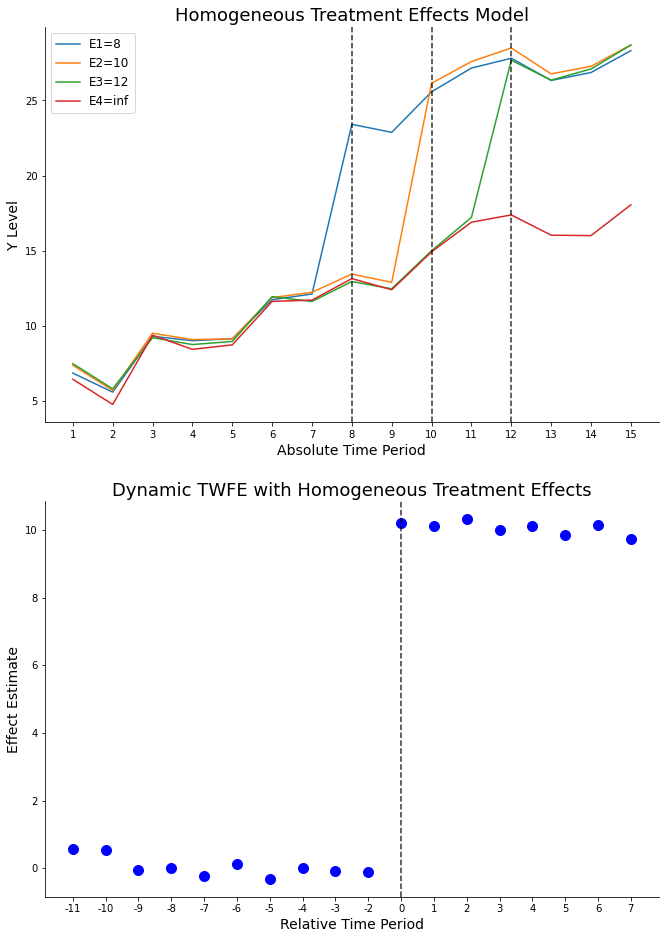

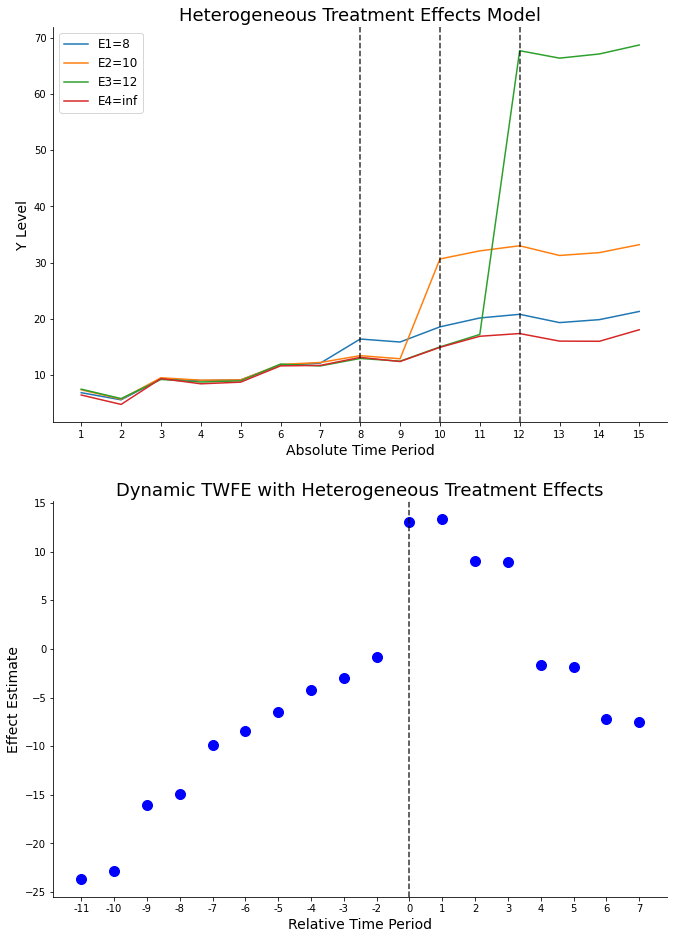

In [10]:
for i in range(len(dfs)):
    fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(11,16))
    ax     = ax.flatten()

    # Formatting stuff
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)

    # Plot 1 main stuff
    ax[0].plot(agg_dfs[i].loc[agg_dfs[i].cohort == 8, 'time'], agg_dfs[i].loc[agg_dfs[i].cohort == 8, 'y'])
    ax[0].plot(agg_dfs[i].loc[agg_dfs[i].cohort == 10, 'time'], agg_dfs[i].loc[agg_dfs[i].cohort == 10, 'y'])
    ax[0].plot(agg_dfs[i].loc[agg_dfs[i].cohort == 12, 'time'], agg_dfs[i].loc[agg_dfs[i].cohort == 12, 'y'])
    ax[0].plot(agg_dfs[i].loc[agg_dfs[i].cohort == 100, 'time'], agg_dfs[i].loc[agg_dfs[i].cohort == 100, 'y'])
    ax[1].scatter(beta_dfs[i]['Coefficient'], beta_dfs[i]['Value'], s=100, color='blue')

    # Vertical/horizontal lines
    ax[0].axvline(x=8, color='black', linestyle='dashed', alpha=0.8)
    ax[0].axvline(x=10, color='black', linestyle='dashed', alpha=0.8)
    ax[0].axvline(x=12, color='black', linestyle='dashed', alpha=0.8)
    ax[1].axvline(x='0', color='black', linestyle='dashed', alpha=0.8)

    # Legend
    ax[0].legend(['E1=8','E2=10','E3=12','E4=inf'], fontsize=12)

    # Axis mess
    ax[0].set_xticks(np.arange(1,T+1))
    ax[0].set_xlabel("Absolute Time Period", size=14)
    ax[0].set_ylabel("Y Level", size=14)
    ax[1].set_xticks(beta_dfs[i]['Coefficient'])
    ax[1].set_xticklabels(reltime_nums)
    ax[1].set_xlabel("Relative Time Period", size=14)
    ax[1].set_ylabel("Effect Estimate", size=14)

    # Titles
    if i == 0:
        ax[0].set_title("Homogeneous Treatment Effects Model", size=18)
        ax[1].set_title("Dynamic TWFE with Homogeneous Treatment Effects", size=18)
    elif i == 1:
        ax[0].set_title("Heterogeneous Treatment Effects Model", size=18)
        ax[1].set_title("Dynamic TWFE with Heterogeneous Treatment Effects", size=18)

    # Save out
    plt.savefig(f"./q7_output/q7c_{i+1}.png")
    plt.show()

# 7(d) - Dynamic TWFE: Leaving out two time indicators

In [11]:
# DGP parameters
N          = 600  # Sample size
T          = 15   # Time periods
i_fe_scale = 5.0  # Individual fixed effects ~ Unif[0, i_fe_scale]
t_fe_scale = 1.0  # Time fixed effects = specified below + N(0, t_fe_scale)
u0_scale   = 2.0  # Variance of noise term added to Y(0)
u1_scale   = 2.0  # Variance of noise term added to Y(1)
baseline   = 2.0  # Baseline level of potential outcome

# How things change over time
t_fe_trend = np.arange(1,T+1) 

# Cohorts
cohorts = np.concatenate((np.repeat(8,  350), 
                           np.repeat(10, 100), 
                           np.repeat(12, 50),
                           np.repeat(100, 100)))

# Treatment effects - homogeneous
effects  = np.concatenate((np.tile(np.repeat(10.0,T), 350), 
                           np.tile(np.repeat(10.0,T), 100), 
                           np.tile(np.repeat(10.0,T), 50),
                           np.tile(np.repeat(10.0,T), 100)))

# Get data 
df,agg_df = gen_data(N, T, cohorts, effects, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)

In [12]:
# Build regression dfs
dfs           = [df.copy()]*5
beta_dfs      = []
reltime_numss = []
for i in range(5):

    reg_df               = dfs[i]
    reg_df['_const']     = 1.0
    
    # Make unit dummies, time dummies, relative time dummies
    unit_dummies         = pd.get_dummies(reg_df['id'])
    time_dummies         = pd.get_dummies(reg_df['time'])
    reltime_dummies      = pd.get_dummies(reg_df['rel'])
    unit_cols            = [f'i: {col}' for col in unit_dummies.columns if col != 1]
    time_cols            = [f't: {col}' for col in time_dummies.columns if col != 1]
    reg_df[unit_cols]    = unit_dummies.drop(1, axis=1)
    reg_df[time_cols]    = time_dummies.drop(1, axis=1)
    reltime_min          = np.min(reltime_dummies.columns)
    reltime_max          = np.max(reltime_dummies.columns)

    # Try 5 different specifications 
    if i == 0:
        reltime_nums         = [f'{int(col)}' for col in reltime_dummies.columns if ((col != reltime_min))]
        reltime_cols         = [f'r: {col}' for col in reltime_nums]
        reg_df[reltime_cols] = reltime_dummies.drop([reltime_min], axis=1)
    if i == 1:
        reltime_nums         = [f'{int(col)}' for col in reltime_dummies.columns if ((col != -1) & (col != reltime_min))]
        reltime_cols         = [f'r: {col}' for col in reltime_nums]
        reg_df[reltime_cols] = reltime_dummies.drop([-1, reltime_min], axis=1)
    if i == 2:
        reltime_nums         = [f'{int(col)}' for col in reltime_dummies.columns if ((col != -5) & (col != reltime_min))]
        reltime_cols         = [f'r: {col}' for col in reltime_nums]
        reg_df[reltime_cols] = reltime_dummies.drop([-5, reltime_min], axis=1)
    if i == 3:
        reltime_nums         = [f'{int(col)}' for col in reltime_dummies.columns if ((col != 1) & (col != reltime_min))]
        reltime_cols         = [f'r: {col}' for col in reltime_nums]
        reg_df[reltime_cols] = reltime_dummies.drop([1, reltime_min], axis=1)
    if i == 4:
        reltime_nums         = [f'{int(col)}' for col in reltime_dummies.columns if ((col != 5) & (col != reltime_min))]
        reltime_cols         = [f'r: {col}' for col in reltime_nums]
        reg_df[reltime_cols] = reltime_dummies.drop([5, reltime_min], axis=1)

    # Get regression matrices
    X = np.array(reg_df[reltime_cols + unit_cols + time_cols + ['_const']])
    y = np.array(reg_df['y'])[:,None]
    
    # Get regression results
    try:
        beta    = (np.linalg.inv(X.T @ X) @ X.T @ y).ravel()
        beta_df = pd.DataFrame({"Coefficient": reltime_nums, 
                                "Value": beta[0:len(reltime_cols)]})
        beta_dfs.append(beta_df)
        
    except np.linalg.LinAlgError:
        print(f"Could not invert matrix for specification #{i}")
        continue

Could not invert matrix for specification #0


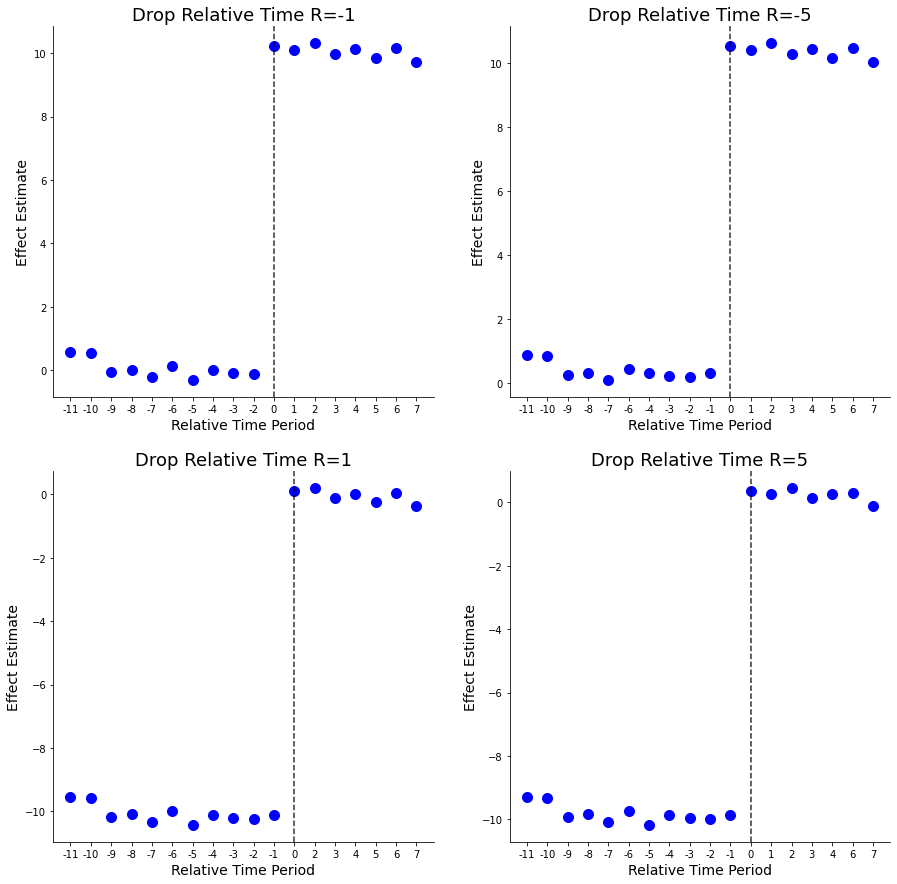

In [13]:
fig,ax = plt.subplots(nrows=int(len(beta_dfs)/2), ncols=2, figsize=(15,15))
ax     = ax.flatten()

titles = [f"Drop Relative Time R={i}" for i in [-1,-5,1,5]]
for i in range(len(beta_dfs)):

    # Formatting stuff
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    # Plot 1 main stuff
    ax[i].scatter(beta_dfs[i]['Coefficient'], beta_dfs[i]['Value'], s=100, color='blue')

    # Vertical/horizontal lines
    ax[i].axvline(x='0', color='black', linestyle='dashed', alpha=0.8)

    # Axis mess
    ax[i].set_xlabel("Relative Time Period", size=14)
    ax[i].set_ylabel("Effect Estimate", size=14)

    # Titles
    ax[i].set_title(titles[i], size=18)

# Save out
plt.savefig(f"./q7_output/q7d.png")
plt.show()

# 7(e) - Comparing Direct and Imputation Estimators

In [14]:
# DGP parameters
N          = 600  # Sample size
T          = 15   # Time periods
i_fe_scale = 8.0  # Individual fixed effects ~ Unif[0, i_fe_scale]
t_fe_scale = 1.0  # Time fixed effects = specified below + N(0, t_fe_scale)
u0_scale   = 3.0  # Variance of noise term added to Y(0)
u1_scale   = 3.0  # Variance of noise term added to Y(1)
baseline   = 2.0  # Baseline level of potential outcome

# How things change over time
t_fe_trend = np.arange(1,T+1) 

# Cohorts
cohorts = np.concatenate((np.repeat(8,  350), 
                           np.repeat(10, 100), 
                           np.repeat(12, 50),
                           np.repeat(np.inf, 100)))

# Treatment effects - heterogeneous
effects = np.concatenate((np.tile(np.repeat(3.0,T),  350), 
                           np.tile(np.repeat(14.5,T), 100), 
                           np.tile(np.repeat(50.0,T), 50),
                           np.tile(np.repeat(10.0,T), 100)))

### Imputation Approach

In [15]:
def imputation_approach(df):
    
    # Add constant
    df['_const'] = 1.0

    # Make cohort dummies - leave out never-treated as constant
    cohort_dummies  = pd.get_dummies(df.cohort)
    cohort_cols     = [f'c: {col}' for col in cohort_dummies.columns if col != np.inf]
    df[cohort_cols] = cohort_dummies.drop(np.inf, axis=1)

    # Make time dummies
    time_dummies    = pd.get_dummies(df.time)
    time_cols       = [f't: {col}' for col in time_dummies.columns if col != 1]
    df[time_cols]   = time_dummies.drop(1, axis=1)

    # Subset to just D_it = 0
    df_d0 = df[df['D'] == 0].copy()

    # Make regression matrices
    X_d0  = np.array(df_d0[time_cols+cohort_cols+['_const']])
    Y_d0  = np.array(df_d0['y'])[:,None]
    X     = np.array(df[time_cols+cohort_cols+['_const']])
    Y     = np.array(df['y'])[:,None]

    # Get inital beta from regression on untreated
    beta_d0 = np.linalg.inv(X_d0.T @ X_d0) @ X_d0.T @ Y_d0

    # Add Ydot and Ytilde 
    df['ydot']   = X @ beta_d0
    df['ytilde'] = df['y']-df['ydot']

    # Drop never treated
    df = df[df.cohort < T]

    # Do aggregation
    df       = df.groupby(['cohort','time']).agg(ytilde=("ytilde","mean"),N=("_const","sum")).reset_index()
    df['Rel. Time'] = (df.time-df.cohort).astype(int)
    wm       = lambda x: np.average(x, weights=df.loc[x.index,"N"])
    imp_df   = df.groupby('Rel. Time').agg(Effect=("ytilde",wm),N=("N","sum")).reset_index()
    imp_df['N'] = imp_df['N'].astype(int)

    return imp_df

In [16]:
df,agg_df = gen_data(N, T, cohorts, effects, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)
imp_df    = imputation_approach(df)
imp_df

,Rel. Time,Effect,N
0,-11,0.892934,50
1,-10,0.536141,50
2,-9,0.200685,150
3,-8,-0.046176,150
4,-7,-0.129584,500
5,-6,0.093517,500
6,-5,-0.170801,500
7,-4,0.005413,500
8,-3,0.028250,500
9,-2,-0.088297,500


### Direct Approach

In [17]:
def direct_approach(df):
    
    # Start with earliest cohort and iterate
    att_dict      = {}
    rel_diff_dict = {}
    for e1 in df.cohort.unique():

        # Skip never-treated
        if e1 == np.inf:
            continue

        # Only loop through years for cohort if they exist
        cohort_size = df[df.cohort == e1]['id'].unique().shape[0]
        for t1 in df.time.unique():

            # Subset to just those necessary for regression
            df_kit1 = copy.deepcopy(df[ 
                 (((df['time'] < e1) | (df['time'] == t1)) & ((df['cohort'] == e1) | (df['cohort'] > t1))) == 1
            ])

            if df_kit1.shape[0] > 0:

                # Make indicator variables for regression
                X      = np.zeros((df_kit1.shape[0],4))
                X[:,0] = np.ones(df_kit1.shape[0])
                X[:,1] = np.array((df_kit1.time == t1).astype(int))
                X[:,2] = np.array((df_kit1.cohort == e1).astype(int))
                X[:,3] = np.array(((df_kit1.time == t1) & (df_kit1.cohort == e1)).astype(int))
                Y      = np.array(df_kit1['y'])[:,None]

                # Get ATT_t(e)
                att = (np.linalg.pinv(X.T @ X) @ X.T @ Y)[-1,0]
                att_dict[(e1,t1)] = (att,cohort_size)

                # Relative time effect
                rel_time = t1-e1
                try:
                    rel_diff_dict[rel_time].append((att,cohort_size))
                except:
                    rel_diff_dict[rel_time] = [(att,cohort_size)]


    # Aggregate!
    results = np.zeros((len(rel_diff_dict),3))
    for j,item in enumerate(rel_diff_dict):
        atts    = np.array([i[0] for i in rel_diff_dict[item]])
        weights = np.array([i[1] for i in rel_diff_dict[item]])
        results[j,0] = int(item)
        results[j,1] = np.average(atts, weights=weights)
        results[j,2] = np.sum(weights)

    # Make dataframe from results
    dir_df = pd.DataFrame(results,columns=['Rel. Time','Effect','N']).sort_values('Rel. Time')
    dir_df['Rel. Time'] = dir_df['Rel. Time'].astype(int)
    dir_df['N']         = dir_df['N'].astype(int)

    return dir_df

In [18]:
# Get data 
df,agg_df = gen_data(N, T, cohorts, effects, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)
dir_df    = direct_approach(df)
dir_df

,Rel. Time,Effect,N
17,-11,2.438016,50
18,-10,2.009864,50
15,-9,1.106665,150
16,-8,0.775137,150
0,-7,-0.085086,500
1,-6,0.466855,500
2,-5,-0.086891,500
3,-4,0.376458,500
4,-3,0.375255,500
5,-2,-0.216674,500


### Get Standard Errors

In [19]:
def block_bootstrap_ses(df, N_boots, method):
    
    # Get list of units
    ids_list  = df.id.unique()
    N_ids     = ids_list.shape[0]
    
    effects_list = [] 
    for i in range(N_boots):
        
        # Resample at the county leve
        df_sample = df.copy()
        df_sample = df_sample.set_index('id').loc[np.random.choice(ids_list, N_ids, replace=True)]
        
        # Get results dataframe
        if method == 'direct':
            effects_list.append(direct_approach(df_sample.reset_index()))
        elif method == 'imputation':
            effects_list.append(imputation_approach(df_sample.reset_index()))
    
    # Aggregate nicely
    bootstraps = np.zeros((effects_list[0].shape[0],effects_list[0].shape[1],N_boots))
    for i in range(len(effects_list)):
        bootstraps[:,:,i] = np.array(effects_list[i])
    
    # Return standard deviation of estimators
    return np.std(bootstraps, axis=2)[:,1]

In [20]:
dir_df['Direct Std.Err']     = np.round(block_bootstrap_ses(df, 200, 'direct'), 4)
imp_df['Imputation Std.Err'] = np.round(block_bootstrap_ses(df, 200, 'imputation'), 4)

### Compare the Two 

In [21]:
# Clean up
imp_df.rename(columns={'Effect':'Imputation'}, inplace=True)
dir_df.rename(columns={'Effect':'Direct'}, inplace=True)
imp_df['Imputation'] = np.round(imp_df['Imputation'], 3)
dir_df['Direct'] = np.round(dir_df['Direct'], 3)

# Combine into one table
res_df = imp_df.merge(dir_df, on=['Rel. Time','N'], how='inner')
res_df['True Effect'] = np.round(
                                 np.concatenate((np.zeros(11),
                                                 np.repeat((3.0*350+14.5*100+50.0*50)/(500.),4),
                                                 np.repeat((3.0*350+14.5*100)/(450),2),
                                                 np.repeat(3.0, 2))),
                                 2)
res_df = res_df[['Rel. Time','N','Direct','Imputation','True Effect',
                 'Direct Std.Err','Imputation Std.Err']]
res_df.to_latex("./q7_output/q7e_table.tex", index=False)
res_df

,Rel. Time,N,Direct,Imputation,True Effect,Direct Std.Err,Imputation Std.Err
0,-11,50,2.438,0.893,0.00,0.3948,0.3275
1,-10,50,2.010,0.536,0.00,0.4727,0.3893
2,-9,150,1.107,0.201,0.00,0.2861,0.2313
3,-8,150,0.775,-0.046,0.00,0.2672,0.2079
4,-7,500,-0.085,-0.130,0.00,0.2419,0.1038
5,-6,500,0.467,0.094,0.00,0.2070,0.0925
6,-5,500,-0.087,-0.171,0.00,0.2037,0.0907
7,-4,500,0.376,0.005,0.00,0.1986,0.0966
8,-3,500,0.375,0.028,0.00,0.2155,0.0971
9,-2,500,-0.217,-0.088,0.00,0.2040,0.0835


In [24]:
(abs(res_df['Direct']-res_df['True Effect'])).sum()/19

0.5597368421052632

In [25]:
(abs(res_df['Imputation']-res_df['True Effect'])).sum()/19

0.25142105263157893